# Baby classifier
*Notebook based on FastAI course v3 lesson 2*

In [1]:
from fastai.vision import *

### Get URLs
Search for images of interest on google and type the following command on the javascript console, this will return a file with the urls for the given search. For this application, I searched for 'happy baby' and 'smiling baby' and combined the results in the file 'urls_happy.csv', I also searched for 'sad baby' and 'crying baby' and combined the results in the file 'urls_sad.csv'

### Create directory

In [2]:
folder = 'happy'
file= 'urls_happy.csv'

In [3]:
path = Path('data/')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [5]:
download_images(path/file, dest, max_pics=500)

In [6]:
folder = 'sad'
file = 'urls_sad.csv'

In [7]:
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [8]:
download_images(path/file, dest, max_pics=500)

In [9]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [10]:
data.classes

['happy', 'sad']

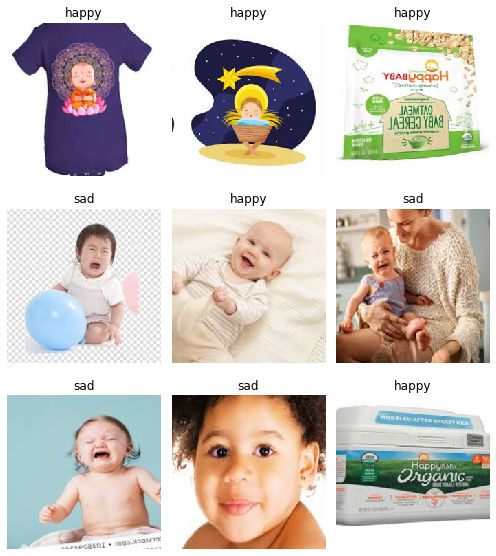

In [11]:
data.show_batch(rows=3, figsize=(7,8))

In [12]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['happy', 'sad'], 2, 576, 144)

In [13]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [14]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.113408,0.757801,0.236111,00:04
1,0.997150,0.691283,0.256944,00:03
2,0.828394,0.518389,0.173611,00:03
3,0.704708,0.515208,0.180556,00:03
4,0.631535,0.504217,0.187500,00:03


In [15]:
learn.save('stage-1')

In [16]:
learn.unfreeze()

In [17]:
learn.lr_find(start_lr=1e-5, end_lr=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


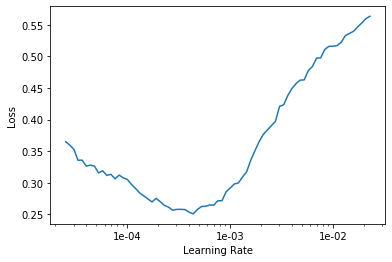

In [18]:
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(10, max_lr=1e-04)

epoch,train_loss,valid_loss,error_rate,time
0,0.459442,0.463587,0.159722,00:03
1,0.388862,0.541768,0.194444,00:04
2,0.333064,0.428233,0.138889,00:04
3,0.286273,0.498441,0.138889,00:04
4,0.249107,0.433224,0.138889,00:04
5,0.220821,0.446236,0.131944,00:04
6,0.194598,0.464421,0.131944,00:04
7,0.173650,0.410746,0.118056,00:04
8,0.153749,0.390908,0.111111,00:04
9,0.134240,0.380557,0.111111,00:04


In [20]:
learn.save('stage-2')

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

In [22]:
interp.confusion_matrix()

array([[82,  9],
       [ 7, 46]])

## Cleaning up

In [ ]:
from fastai.widgets import *

In [ ]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [ ]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [ ]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [ ]:
ImageCleaner(ds, idxs, path)

In [ ]:
db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
                    .split_none()
                    .label_from_df()
                    .transform(get_transforms(), size=224)
                    .databunch()
      )

In [ ]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [ ]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

In [ ]:
ImageCleaner(ds, idxs, path, duplicates=True)

## Training the model with the cleaned data

In [23]:
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

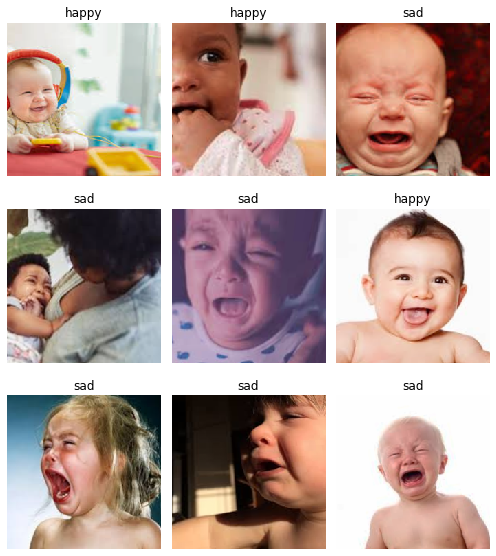

In [24]:
data.show_batch(rows=3, figsize=(7,8))

In [25]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [30]:
learn.load('stage-2');

In [27]:
learn.lr_find(start_lr=1e-5, end_lr=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


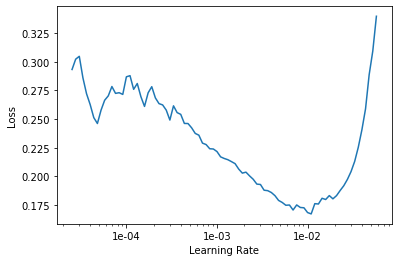

In [28]:
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(5, max_lr=slice(1e-04, 1e-03))

epoch,train_loss,valid_loss,error_rate,time
0,0.261556,0.092113,0.021505,00:02
1,0.229512,0.080673,0.021505,00:02
2,0.187081,0.092237,0.010753,00:02
3,0.180899,0.096469,0.010753,00:02
4,0.165979,0.099020,0.010753,00:02


In [32]:
learn.save('stage-3')

In [33]:
interp = ClassificationInterpretation.from_learner(learn)

In [34]:
interp.confusion_matrix()

array([[42,  0],
       [ 1, 50]])

## Putting the model in production

In [35]:
learn.export()

In [36]:
defaults.device = torch.device('cpu')

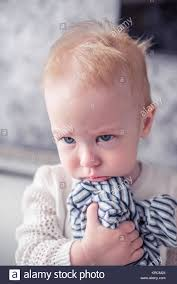

In [37]:
img = open_image(path/'sad'/'00000021.jpg')
img

In [38]:
learn = load_learner(path)

In [39]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category sad